
<div style="height:40px"><h2 style="align-content:center;padding:10px;color:white;background-color:#A4644E;float:left;margin-top:0px">Máster en Big Data y Data Science</h2>
<h2  style="align-content:center;padding:10px;color:white;background-color:#E0A030;float:left;margin-top:0px;">Fundamentos de análisis de datos</h2></div>


# Daniel Perez Efremova - Santiago Queipo de Llano

## Árboles de decisión
En este ejercicio vamos a ver el funcionamiento básico de los árboles de decisión. Haremos algunos ejemplos en problemas en 2D para su visualización y otros problemas para ver sus capacidades y debilidades. Al final del ejercicio serás capaz de:
<ul>
<li>Describir el mecanismo utilizado por los árboles de decisión para construir modelos reduciendo la impureza de los datos</li>
<li>Reconocer el aspecto de las fronteras de decisión de los árboles</li>
<li>Comprobar cómo varía la estructura del árbol modificando el número de ejemplo mínimos que cae en cada hoja</li>
<li>Medir tiempo de entrenamiento de los árboles con respecto al número de ejemplos</li>
</ul>

In [5]:
# Hacemos los imports necesarios
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
import numpy.matlib as matl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### 1.- Cómo encontrar la mejor división en los datos: Crieterio de Gini
Vamos a implamentar una serie de funciones para encontrar la mejor división de los datos usando el criterio de Gini. Para ello vamos a implementar rtes funciones.

##### Función de impureza
Vamos a implementar una función para la impureza de Gini que se usa en los árboles CART:

$$
i(t) = \sum_{i=1}^{M} f_{i} (1-f_{i})
$$

La función recibe una lista con el histograma con el número de ejemplos para cada clase. Debe devolver su impureza.

In [6]:
# impurityGini: Calcula la impureza de Gini
#    Entrada: 
#      -fs: lista/vector con el histograma con el número de ejemplos
#           para cada clase.
#    Salida:
#      -i(t): Impureza
def impurityGini(fs):
    fs_norm = fs/float(sum(fs))
    return sum(fs_norm*(1-fs_norm))

#  Implementación con bucles seria
#  fs_norm = fs/float(sum(fs))
#  s = 0
#  for fi in fs_norm:
#      s + = fi*(1-fi)
#  return s

##### Tests función de impureza

In [7]:
tolerancia = 0.000000001
# Usando número de ejemplos. Debe devolver 0.44444444
num_ejemplos = np.array([4.,8.])
assert(abs(impurityGini(num_ejemplos)-4./9)<tolerancia)

# Usando clases puras. Debe devolver 0
num_ejemplos = np.array([12.,0.])
assert(abs(impurityGini(num_ejemplos))<tolerancia)

# Usando clases equilibradas. Debe devolver 0.5
num_ejemplos = np.array([6.,6.])
assert(abs(impurityGini(num_ejemplos)-0.5)<tolerancia)

# Usando 4 clases y equilibradas. Debe devolver 0.75
num_ejemplos = np.array([4.,4.,4.,4.])
assert(abs(impurityGini(num_ejemplos)-0.75)<tolerancia)

# Usando 4 clases deequilibradas. Debe devolver 0.5546875
num_ejemplos = np.array([8.,0.,7.,1.])
assert(abs(impurityGini(num_ejemplos)-0.5546875)<tolerancia)

print("Todo OK")

Todo OK


##### Grafica de función de impureza

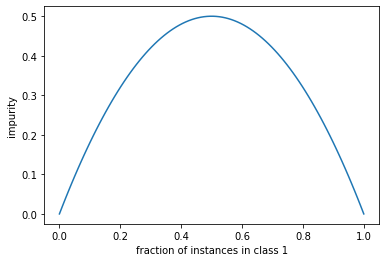

In [8]:
# Debe mostrar una gráfica con una parábola invertida
fracciones = np.linspace(0,1,100)
impurities = list(map(impurityGini,np.array(list(zip(fracciones,1-fracciones)))))
plt.ylabel("impurity")
plt.xlabel("fraction of instances in class 1")
_ = plt.plot(fracciones, impurities)

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Viendo la gráfica responde a las siguientes preguntas:
<ul>
<li>(1) ¿En qué punto se alcanza la mayor impureza de los datos? ¿A qué distribución de clases correnpondería?</li>
<li>(2) ¿En qué punto se alcanza la menor impureza de los datos? ¿A qué distribución de clases correnpondería?</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
Para resolver el ejercicio se estudia la monotonía de la función de Gini y se demuestra la existencia de dos mínimos y un máximo. Consideremos la función continua $g(x)=x(1-x)$ tal que $x\in[0,1]$. Es inmediato que $g'(x)=1-2x$. Imponiendo $g'(x)=0$ se tiene que en $x=\frac{1}{2}$ la función tiene un cambio de signo en la derivada. Como $g'(x)<0$ si $x<\frac{1}{2}$ y $g'(x)>0$ si $x>\frac{1}{2}$ se tiene que la función es monótona creciente en $0\le x \le \frac{1}{2}$ y monótona decreciente en $\frac{1}{2}\le x \le 1$. Por ser $g(x)$ continua y estar $x$ definida en un intervalo cerrado y acotado (Teorema de Weiertrass) la función alcanza sus mínimos y máximos en dicho intervalo cerrado. Por la monotonía de $g(x)$ se ve que tiene dos mínimos en los extremos del intervalo $x=0$ y $x=1$. Por el cambio de monotonía se ve que $x=\frac{1}{2}$ es un máximo.
<li>(1): Siguiendo el argumento anterior, se alcanza el mínimo si $x=1$ o $x=0$. Se interpreta que al ser $x$ la frecuencia de una de las clases, entonces, si $x=1$, el conjunto solo contiene una de las dos clases y viceversa. Y se entiende que el conjunto no tiene impureza, ya que solo contiene elementos de una única naturaleza.</li>
<li>(2): Siguiendo con el argumento anterior, el máximo se obtiene si $x=1-x=\frac{1}{2}$. Se interpreta que al ser $x$ la frecuencia de una de las clases, entonces, si $x=\frac{1}{2}$, el conjunto contiene la misma proporción de las dos clases. Y se entiende que el conjunto tiene el máximo nivel de impureza, es decir, dos elementos de naturalezas distintas mezclados a partes iguales.</li>
</ul>
</div>

##### Función para calcular la reducción de impureza
Vamos a implementar una función de variación de impureza para un nodo $t$ y división $s$ utilizado en los árboles CART:

$$
\Delta i(t, s) = i(t) - p_L \times i(t_L) - p_R \times i(t_R)
$$

La función recibe una lista con los histogramas o fracción de ejemplos para cada clase para el nodo derecho e izquierdo y te devuelve la variación de impureza.

In [9]:
# impurityReduction: Calcula la reducción de impureza de Gini a partir
#      de las distribuciones de ejemplos en el nodo derecho e izquierdo.
#      para saber la distribución antes de la división hay que sumar
#      fs_left y fs_right
#    Entrada: 
#      -fs_left:  lista/vector con el histograma de ejemplos
#                 para cada clase que van al nodo izq tras la división.
#      -fs_right: lista/vector con el histograma o fraccion de ejemplos
#                 para cada clase que van al nodo dcho tras la división.
#    Salida:
#      -Delta i(t): Variación de la impureza
def impurityReduction(fs_left, fs_right):
    it = impurityGini(fs_left+fs_right)
    iL = impurityGini(fs_left) 
    iR = impurityGini(fs_right)
    sL = sum(fs_left)
    sR = sum(fs_right)
    return it - iL*sL/(sL+sR) - iR*sR/(sL+sR)


##### Tests función impurityReduction

In [10]:
tolerancia = 0.000000001

#Debe devolver 0.5
lf = np.array([4.,0.])
rg = np.array([0.,4.])
assert(abs(impurityReduction(lf,rg)-0.5)<tolerancia)

#Debe devolver 0.11111111111
lf = np.array([4.,0.])
rg = np.array([4.,4.])
assert(abs(impurityReduction(lf,rg)-0.1111111111111)<tolerancia)

#Debe devolver 0
lf = np.array([4.,4.])
rg = np.array([4.,4.])
assert(abs(impurityReduction(lf,rg))<tolerancia)

print("Todas OK")

Todas OK


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Viendo los valores de las pruebas responde a las siguientes preguntas:
<ul>
<li>(3) ¿Qué división se hace cuando se reduce 0'5 la impureza (caso 1 arriba)? ¿Qué distribución de clases tienen antes de la división?¿Y después?</li>
<li>(4) ¿Qué división se hace cuando no se reduce la impureza (caso 3 arriba)? ¿Qué distribución de clases tienen antes de la división?¿Y después?</li>
</ul>
</div>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li>(3): En el caso 1 se tiene que $\Delta i(t, s) = 0.5$, veamos por qué observando el conjunto de orígen. Se ven 4 elementos de una clase y 4 de la contraria. Por tanto, por el ejercicio anterior la impureza del nodo es $i(t)=0.5$. Por otro lado, despues del split, se tiene que la proporción de observaciones en las hojas izquierda y derecha es igual a $\frac{4}{8}=\frac{1}{2}$, luego $p_L=p_R=\frac{1}{2}$. Por último, por el ejercicio anterior, sabemos que las hojas izquierda y derecha dan lugar a un nodo con la mínima impureza (solo una clase) luego $i(t_L)=i(t_R)=0$. Así se tiene que la reducción de impureza $\Delta i(t, s) = 0.5$ se obtiene por un split que separa por completo dos clases.</li>
<li>(4): En el caso 3 se tiene que $\Delta i(t, s) = 0$, veamos por qué observando los conjuntos izquierdo y derecho. Se observa que el conjunto de entrada al nodo es (8, 8), dos elementos de naturaleza distinta mezclados a partes iguales, luego tienen el máximo nivel de impureza $i(t)=\frac{1}{2}$. En el resultado del split en izquierda y derecha se vuelve a repetir la situación de entrada con (4,4) en ambos. Luego se tiene que $i(t_L)=i(t_R)=\frac{1}{2}$. Además, se reparte la mitad de las observaciones de entrada a izquierda y la otra a derecha, por lo que $p_L = p_R = \frac{1}{2}$. Operando, finalmente tenemos:
$$\Delta i(t, s) = \frac{1}{2} - \frac{1}{2}\frac{1}{2} - \frac{1}{2}\frac{1}{2} = 0$$
es decir, la división de un conjunto con el máximo nivel de impureza en otros dos conjuntos con el máximo nivel de impureza resulta en un 0 en reducción de impureza.
    </li>
</ul>
</div>

##### Función para calcular la mejor partición a partir de un conjunto de datos
Esta función debe recorrer todos los atributos (columnas) de los datos y calcular todas las posibles divisiones recorriendo valores de los ejemplos ordenados (filas).

La función recibe una matriz X con los datos y un vector y con las clases para cada dato donde la primera clase es la 0, la segunda la 1, etc. Debe devolver el atributo donde se ha encontrado la mejor división y el umbral de corte.

In [11]:
# findBestSplit: Busca la mejor partición de los datos usando el criterio de Gini
#
#    Entrada: 
#     - X: Matriz de ejemplos con atributos en columnas y datos en filas
#      -y: Vector con las clases de cada ejemplo. Debe ser de la misma 
#          longitud que el numero de filas de X
#    Salida:
#      -atributo de la división 
#      -valor para el corte
def findBestSplit(X, y):
    assert(X.shape[0]==len(y))
    irmax = 0
    for ia in range(X.shape[1]):           # Recorremos atributos
        idx         = np.argsort(X[:,ia])      # Ordenamos los datos por el atributo de índice ia
        attr_sorted = X[idx,ia]
        y_sorted    = y[idx]
        hist_left   = np.array([0.0, 0.0])     # Inic num. ejemplos en hoja izq -> ninguno
        hist_right  = np.bincount(y)           # Inic. num. ejemplos en hoja dcha -> todos
        for isplit in range(X.shape[0]-1): # Recorremos las posibles divisiones
            hist_left[y_sorted[isplit]]  += 1.0    # Actualizamos histogramas de num. ejemplos añadiendo a hoja izq
            hist_right[y_sorted[isplit]] -= 1.0    #                                        y eliminando de la dcha
            if attr_sorted[isplit] != attr_sorted[isplit+1]: # Si este dato y el siguiente son distintos se calcula
                ir = impurityReduction(hist_left, hist_right)    # la reducción de impureza
                if ir > irmax:                                   # Si mejoramos guardamos el atrib. y umbral corte
                    irmax = ir
                    iatt_best = ia
                    threshold_best = attr_sorted[isplit] + (attr_sorted[isplit+1] - attr_sorted[isplit])/2.
            
    return iatt_best, threshold_best


In [12]:
# Ejemplo del ppt
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Debe devolver (1, 3.5)
findBestSplit(X,clase)

(1, 3.5)

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Viendo el funcionamiento de la función:
<ul>
<li> (5) Describe cómo es el prodecimiento para buscar la mejor división en los árboles de decisión</li>
</ul>
</div>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li>(5): El proceso iterativo consiste en:$\\$
    0) Inicializar la reducción de impureza en 0 $\\$
    1) Elegir un atributo, ordenar los valores del atributo y los target (0,1) en función de los índices anteriores, e inicializar los  histogramas con un nodo raíz ficticio. Los histogramas comienzan en (0,0) en izquierda y (m,n) en la derecha$\\$
    2)  Recorrer todos los valores del atributo. En cada iteración, en el histograma de izquierda se suma uno a la clase que pertenezca el valor del atributo y se resta en derecha (para probar todos los split). Es decir, los histogramas, en cada iteración, se intercambian una unidad dependiendo de la clase a la que pertenezca el atributo. $\\$
    3) Calcular la reducción de impureza del split con la función del ejercicio anterior.$\\$
    4) Si la reducción es mayor que en el máximo hasta el momento, se acutalizan: el valor maximo, la mejor variable y el umbral mediante el valor del punto medio entre el actual y el siguiente. En caso contrario, continuar.$\\$
    El proceso continua hasta que se han probado todos los posibles splits. $\\$
    ** Existen implementaciones que integran una divisón de los atributos en bins de tamaño moderado y se seleccionan las variables a iterar mediante un test de independencia de la chi cuadrado con respecto a la target. Muy interesante como eficiencia a esta implementación que prueba absolutamente todas las combinaciones para cada atributo y su valor.</li>
</ul>
</div>

recurso visitado: https://www.researchgate.net/figure/The-pseudocode-of-classification-and-regression-tree_fig2_327252498

### 2.- Conjuntos en 2D para el anáilisis visual de las fronteras de decisión y cómo cambian con algunos parámetros

##### Funciones auxiliares
Antes definiremos algunas funciones (autores Luis Lago y Manuel Sanchez Montañes) que usaremos a lo largo de la práctica. La primera, *createDataSet*, es para crear los problemas, siempre con dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [13]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, c, xbnd, ybnd
    else:
        return x, y, c

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [14]:
def plotModel(x,y,clase,clf,title):
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter([x[clase==0]], [y[clase==0]], c='#FF0000')
        plt.scatter([x[clase==1]], [y[clase==1]], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [15]:
def plotData(x,y,c,style0,style1,title):
    plt.plot(x[c==0],y[c==0],style0)
    plt.plot(x[c==1],y[c==1],style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

#### Visualizar el árbol
Se entrena un árbol usando los datos del ppt y visualizamos su estructura y la frontera de decisión

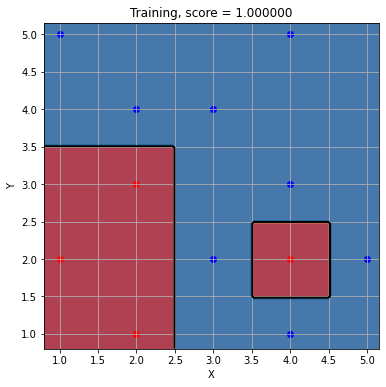

In [41]:

# Datos
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Declaración del clasificador:
clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=1, max_depth=None)   # Rellenar

# Entrenar el clasificador
clf.fit(X, clase)                                       # Rellenar

# Clasificar datos
score_train = clf.score(X, clase)

# Frontera de decisión:
plt.figure(figsize=(6,6))
plotModel(X[:,0],X[:,1],clase,clf,"Training, score = %f" % (score_train))



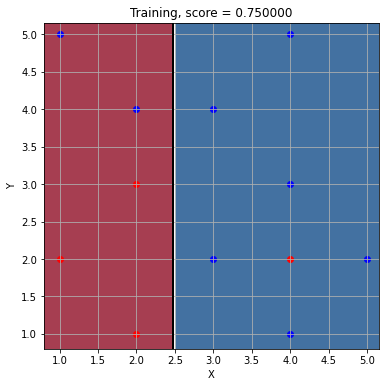

In [59]:

# Datos
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Declaración del clasificador:
clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=5, max_depth=None)   # Rellenar

# Entrenar el clasificador
clf.fit(X, clase)                                       # Rellenar

# Clasificar datos
score_train = clf.score(X, clase)

# Frontera de decisión:
plt.figure(figsize=(6,6))
plotModel(X[:,0],X[:,1],clase,clf,"Training, score = %f" % (score_train))

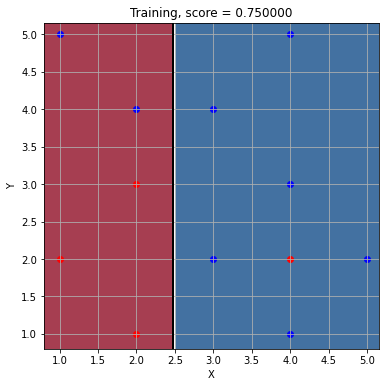

In [72]:

# Datos
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Declaración del clasificador:
clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=5, max_depth=1)   # Rellenar

# Entrenar el clasificador
clf.fit(X, clase)                                       # Rellenar

# Clasificar datos
score_train = clf.score(X, clase)

# Frontera de decisión:
plt.figure(figsize=(6,6))
plotModel(X[:,0],X[:,1],clase,clf,"Training, score = %f" % (score_train))

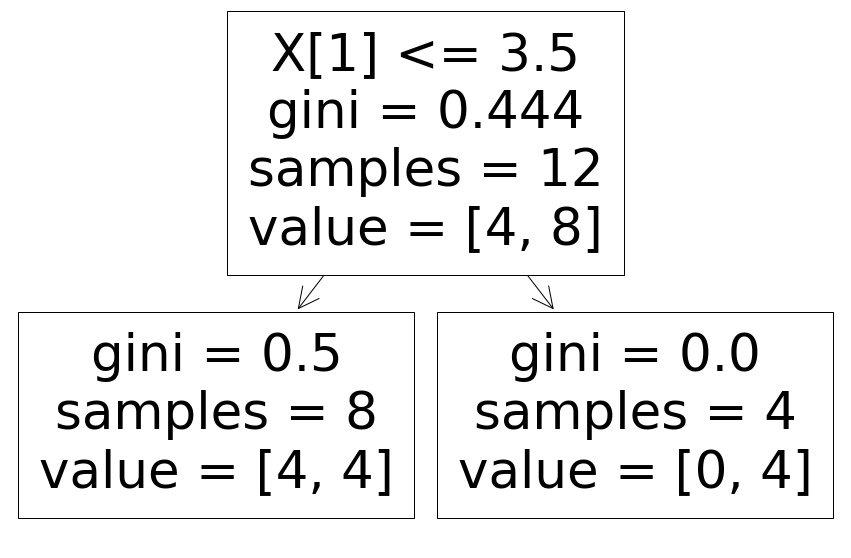

In [70]:
plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf)

<div style="background-color:#AAEEAA;padding:20px;border:solid;">
<ul>
<li> (6) Modifica parámetros de construcción del árbol para obtener un árbol más compacto que elimine el cuadrado rojo de abajo a la derecha. Indica qué parámetro has modificado y explica las diferencias que creeís que hay entre los árboles que usan prepoda con max_depth o con min_samples_leaf.</li>
</ul>
</div>
<p></p>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li>(6): min_samples_leaf controla la cantidad de observaciones que debe haber como máximo en un nodo para que siga ramificando el árbol a través de ese nodo. Puede controlar el overfitting no permitiendo que el arbol siga dividiendo el espacio en regiones cada vez más ajustadas a un subconjunto concreto del conjunto de entrenamiento. $\\$
max_depth controla la cantidad de niveles que puede tener el árbol. Limitando la cantidad de niveles a $d$, la cantidad de hojas (sin limitar el mínimo de observaciones por nodo) que pueden crearse son $2^d$. En general un árbol con número de hojas pequeño (regiones generadas) es poco propenso al overfitting si el tamaño muestral es suficientemente grande.
    
</li>
</ul>
</div>

recurso visitado: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

##### Ejemplo con funciones más complejas



<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ejecuta las dos celdas siguientes utilizando 0 ruido en los datos y un ruido de 0.3. Después prueba con min_samples_leaf 1 y 10 para cada uno de los niveles de ruido y rellena el acierto en test y train en la siguiente tabla:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(7) Respuestas:
 <table>
  <tr>
    <td>Acierto train/test</td>
    <td>min_samples_leaf=1</td>
    <td>min_samples_leaf=10</td>
  </tr>
  <tr>
    <td>noise=0</td>
    <td> 1 - 0.93</td>
    <td>0.93 - 0.89 </td>
  </tr>
  <tr>
    <td>noise=0.3</td>
    <td> 1 - 0.83</td>
    <td> 0.89 - 0.86 </td>
  </tr>
</table> 
</div>

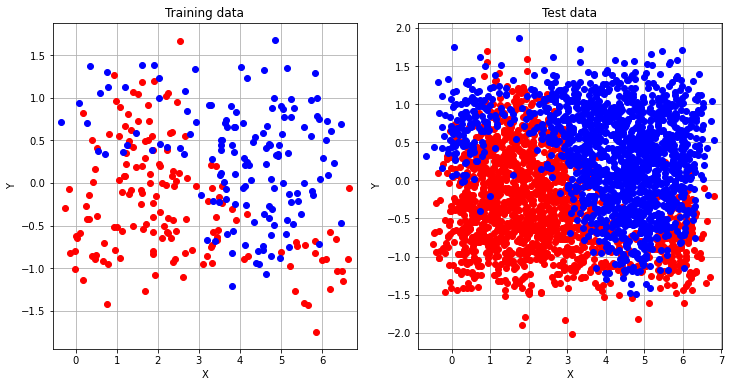

In [81]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                         # <========= Modifica este valor 0 ó 0.3
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)

# Plots:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotData(x,y,clase,'ro','bo',"Training data")
plt.subplot(122)
plotData(xtest,ytest,clasetest,'ro','bo',"Test data")

Score train = 0.896667
Score test = 0.868333


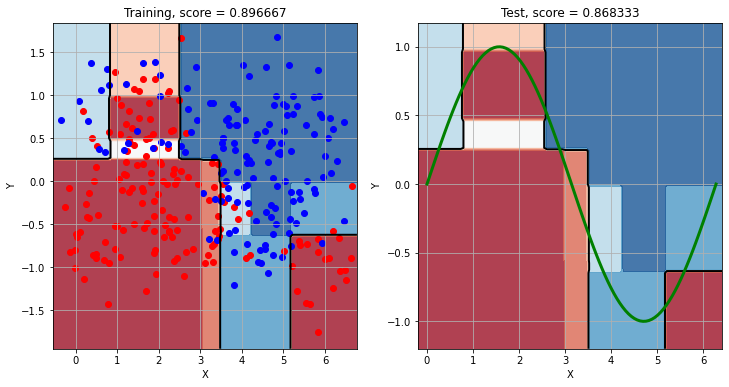

In [82]:
# Construcción del clasificador:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)     # <========= Modifica este valor 1 ó 10
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

A continuación vamos a realizar un bucle para calcular el acierto del árbol en train y test con respecto al parámetro min_samples_leaf usando ruido (noise=0.3). Entrena árboles usando min_samples_leaf de 1 a 30. Muestra los datos en forma de gráfica usando matlibplot


In [ ]:
mins_samples = range(1,30)
scores_tr = np.array([0.]*len(mins_samples))
scores_ts = np.array([0.]*len(mins_samples))
i=0
for m in mins_samples:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=m)
    clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  
    # Calculo del acierto en los conjuntos de entrenamiento y test:
    scores_tr[i] = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
    scores_ts[i] = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
    i = i + 1

plt.plot(mins_samples, scores_tr, label='train')
plt.plot(mins_samples, scores_ts, label='test')
plt.xlabel("Min ejemplos por hoja")
plt.ylabel("Acierto")
_ = plt.legend()

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica (si la has hecho) describe qué valores de min_leaf os dan mejores resultados dependiendo del ruido introducido en los datos y da una justificación a los resultados <br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">
    (8) Respuesta: Sin ruido el mejor resultado se obtiene para min_leaf=1. Si el conjunto de datos es determinista, no se precisa de generalización en el modelo (el proceso que se esta midiendo no se perturba) por lo que un modelo que se ajuste a cada caso concreto se puede considerar aceptable y da buenos resultados en trian y test. Sin embargo, en presencia de ruido es necesario que el modelo pueda generalizar. Para ello, se usa la prepoda con min_leaf=10. Esto limita el numero de splits que se pueden hacer y hace que el arbol no pueda ajustarse de manera exacta a una observación. Se ve que en train pierde capacidad de clasificación pero sobre datos nunca observados se comporta mejor que el modelo que puede ajustarse a una sola observación.

</div>

### 3.- Tiempos de entrenamiento y test de los árboles de decisión
Vamos a medir tiempos de entrenamiento y clasificación de árboles de decisión y a compararlos con los tiempos de las SVMs. Probaremos a entrenar los modelos con 300 datos y con 600


In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 600                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con %d ejemplos: %f s." % (len(indices_train),(toc - tic)/n_executions))

n_executions = 1000

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 1000000.
print("Tiempo de clasificar %g ejemplos: %f s." % (factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 600 ejemplos: 51.569054 s.
Tiempo de clasificar 1e+06 ejemplos: 7.194858 s.


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Se debe ejecutar la celda de arriba utilizando árboles o SVMs para medir tiempos de entrenamiento y de clasificación. Hazlo usando 300 datos de entrenamiento y 600. A continuación se debe rellenar los tiempos en la siguiente tabla:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(9) Respuestas:
 <table>
  <tr>
    <td>Tiempos (s) train</td>
    <td>Árbol</td>
    <td>SVM</td>
  </tr>
  <tr>
    <td>Entrenamiento con 300 </td>
    <td>0.0027 s</td>
    <td>3.384 s</td>
  </tr>
  <tr>
    <td>Entrenamiento con 600</td>
    <td>0.0028 s</td>
    <td>22.256 s</td>
  </tr>
  <tr>
    <td>Clasificación (10^6 ejemplos)</td>
    <td>0.773 s</td>
    <td>3.647 s</td>
  </tr>
  <tr>
    <td>Clasificación (10^6 ejemplos)</td>
    <td> 1.083 s</td>
    <td>7.391 s</td>
  </tr>
</table> 
</div>
<br/>


In [91]:
import timeit
# Compute training and testing time

# Cargamos datos
fP = 'pimaND.csv'     # <========== Se puede variar el conjunto de datos.
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1)
clf = tree.DecisionTreeClassifier()

n_steps = 10           # <========== Se puede variar el numero de paso
n_executions = 1

times_tr = np.array([timeit.default_timer()] * n_steps)
sizes    = np.array([0] * n_steps)
times_ts = np.array([timeit.default_timer()] * n_steps)
sizes_ts = np.array([0] * n_steps)

i = 0
perm = np.random.permutation(dfP.shape[0])
for fraction in  np.linspace(0.1, 0.90, num=n_steps):
    n_train = int(len(perm)*(fraction))
    idxTr = perm[0:n_train]  # PArticion de train
    idxTs = perm[n_train:]   # Particion de test
    
    # Train
    tic = timeit.default_timer()
    for ie in range(n_executions):
        clf.fit(dfP.values[idxTr,:-1],dfP.values[idxTr,-1])
    toc = timeit.default_timer()
    times_tr[i] = (toc - tic)/n_executions
    sizes[i] = len(idxTr)
    
    # Test
    tic = timeit.default_timer()
    for ie in range(n_executions*10):
        _ = clf.predict(dfP.values[idxTs,:-1])
    toc = timeit.default_timer()
    factor = 1000000.
    times_ts[i] = factor*(toc - tic)/n_executions/len(idxTs)/10
    
    i = i + 1
        


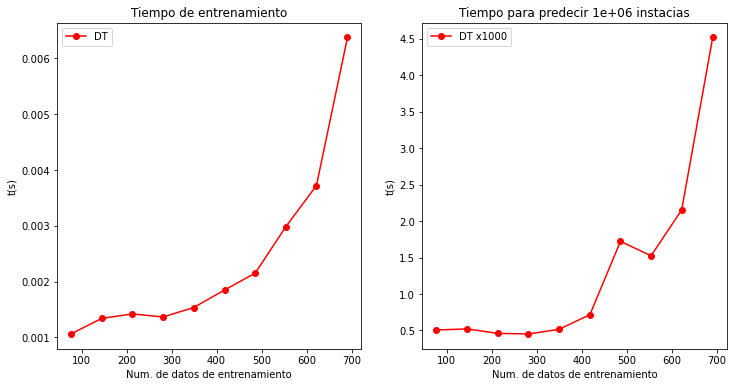

In [92]:
plt.figure(figsize=(12,6))
plt.grid()
plt.subplot(121)
plt.title('Tiempo de entrenamiento')
plt.xlabel("Num. de datos de entrenamiento")
plt.ylabel("t(s)")
plt.plot(sizes, times_tr, 'o-', color="r", label="DT")
plt.legend()
plt.subplot(122)
plt.title('Tiempo para predecir %g instacias' %(factor))
plt.xlabel("Num. de datos de entrenamiento")
plt.ylabel("t(s)")
plt.plot(sizes, times_ts, 'o-', color="r", label="DT x1000")
plt.legend()

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica (si la has hecho) comenta los resultados.<br/>

<ul>
<li>(10) ¿Cómo varían los tiempos de entrenamiento al doblar el número de datos de entrenamiento? ¿Y los tiempos de clasificación?</li>
<li>(11): Explica los resultados</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuesta:

<ul>
<li>(10): Con los árboles el tiempo de entrenamiento no varía significativamente en entrenamiento aunque en clasificación se triplica. En el caso de SVMs el tiempo aumenta muy significativamente se multiplica por 7 el tiempo de entrenamiento al doblar el tamaño de entrenamiento. Para clasificar solo se duplica ganando eficiencia respecto a los arboles. </li>
<li>(11): Se ve que en entrenamiento, los arboles son mas eficientes. Esto se explica porque los splits son optimos independientemente del tamaño de entrenamiento y se calculan mediante busqueda a lo sumo lineal. Aunque para clasificar se debe recorrer todo el arbol, lo cual relentiza la clasificación. Por el contrario SVM son lentas en entrenamiento porque deben calcular el optimo de manera determinista y dependiendo del tamaño de los datos se deben hacer demasiados calculos. Sin embbargo, la solución al problema de optimización es una función analítica por lo que las clasificaciones se hacen de manera mas sencilla por sustitución, reduciendo el tiempo respecto a  los arboles.</li>
</ul></div>